In [21]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import scipy.sparse as sp
from scipy.sparse import coo_matrix

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

In [2]:
print('Loading Data...')

data_path ='..\\input\\'
train = pd.read_csv(data_path + 'train.csv', encoding='utf-8', dtype = {'target': np.int32})
test = pd.read_csv(data_path + 'test.csv' , encoding='utf-8')
songs = pd.read_csv(data_path + 'songs.csv', encoding='utf-8')
members = pd.read_csv(data_path + 'members.csv', encoding='utf-8', parse_dates = ['expiration_date', 'registration_init_time'])
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv', encoding='utf-8')

print('........Loaded')
print('train data has {} rows'.format(train.shape[0]))
print('test data has {} rows'.format(test.shape[0]))
print('songs data has {} rows'.format(songs.shape[0]))
print('members data has {} rows'.format(members.shape[0]))
print('songs_extra data has {} rows'.format(songs_extra.shape[0]))


Loading Data...
........Loaded
train data has 7377418 rows
test data has 2556790 rows
songs data has 2296320 rows
members data has 34403 rows
songs_extra data has 2295971 rows


#### Basic Info : count for test and train

In [3]:
# target variable is balanced:
print("The percent of target variable that equals to 1 is: {:.2f}".format(
    len(train.loc[train.target==1, 'target'])/train.shape[0]))

The percent of target variable that equals to 1 is: 0.50


In [4]:
# number of unqiue variables, including nan, in train and test

common_list=['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type']
for col in common_list:
    t = ['nan' if x is np.nan else x for x in train[col].unique().tolist()]
    s = ['nan' if x is np.nan else x for x in test[col].unique().tolist()]
    print("Unique value of {}: {:,} in train. {:,} in test. {:,} in both rain and test. Test has {} more values".format(
        col,
        len(t),
        len(s),
        len(set(t)&set(s)),
        len(set(t)|set(s))-len(t)))


Unique value of msno: 30,755 in train. 25,131 in test. 21,483 in both rain and test. Test has 3648 more values
Unique value of song_id: 359,966 in train. 224,753 in test. 164,880 in both rain and test. Test has 59873 more values
Unique value of source_system_tab: 10 in train. 10 in test. 10 in both rain and test. Test has 0 more values
Unique value of source_screen_name: 21 in train. 23 in test. 21 in both rain and test. Test has 2 more values
Unique value of source_type: 13 in train. 13 in test. 13 in both rain and test. Test has 0 more values


In [10]:
# Unique Values
def unique_print(df):   
    for i in df.columns:  
        print(i, df[i].nunique())
    print('.................')
    
unique_print(songs)
unique_print(members)
unique_print(songs_extra)


song_id 2296320
song_length 146534
genre_ids 1045
artist_name 222363
composer 329824
lyricist 110926
language 10
.................
msno 34403
city 21
bd 95
gender 2
registered_via 6
registration_init_time 3862
expiration_date 1484
.................
song_id 2295971
name 1168979
isrc 1806825
.................


#### merging

In [36]:
print("Appending...")
df = pd.concat([train, test])
df.drop('id', axis=1, inplace=True)


print("Merging...")
df = pd.merge(df, songs, on = 'song_id', how = 'left')
df = pd.merge(df, members, on = "msno", how = 'left')
df = pd.merge(df, songs_extra, on = "song_id", how = 'left')


Appending...
Merging...


In [18]:
# describe numeric vars
pd.options.display.float_format = '{:20,.2f}'.format
def describe(df, val, percentile):
    print(df[val].describe(percentile))
    
describe(df,['bd','song_length'], [0.001, 0.25, 0.5, 0.75,0.999])

                        bd          song_length
count         9,934,208.00         9,934,069.00
mean                 17.50           244,792.19
std                  21.73            68,942.72
min                 -43.00             1,393.00
0.1%                  0.00            40,575.88
25%                   0.00           214,413.00
50%                  21.00           240,960.00
75%                  29.00           271,568.00
99.9%                87.00           813,996.44
max               1,051.00        10,851,706.00


### Visual exploration

#### Data is ordered chronilogically

In [50]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)

train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')

train['2017_songs_frac'] = (train['song_year'] == 2017).rolling(window = 50000, center = True).mean()
test['2017_songs_frac'] = (test['song_year'] == 2017).rolling(window = 50000, center = True).mean()


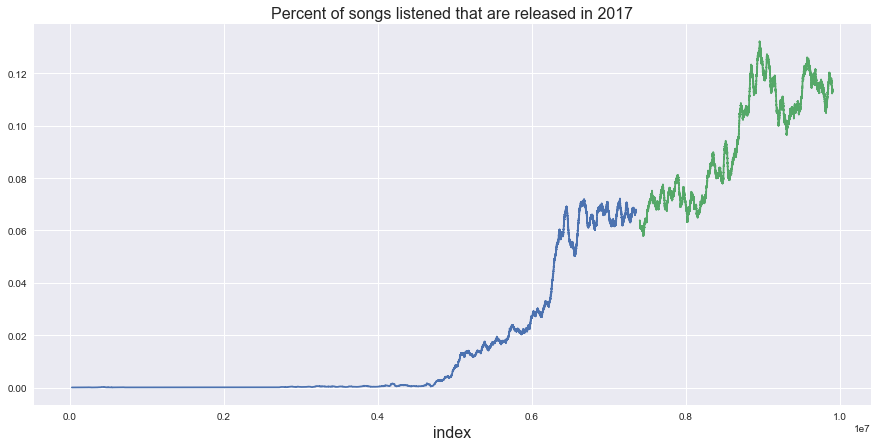

In [53]:
plt.figure(figsize=(15,7))
plt.title('Percent of songs listened that are released in 2017', fontsize=16)
plt.plot(train.index.values, train['2017_songs_frac'], '-')
plt.plot(n + test.index.values, test['2017_songs_frac'], '-')
plt.xlabel('index', fontsize=16)

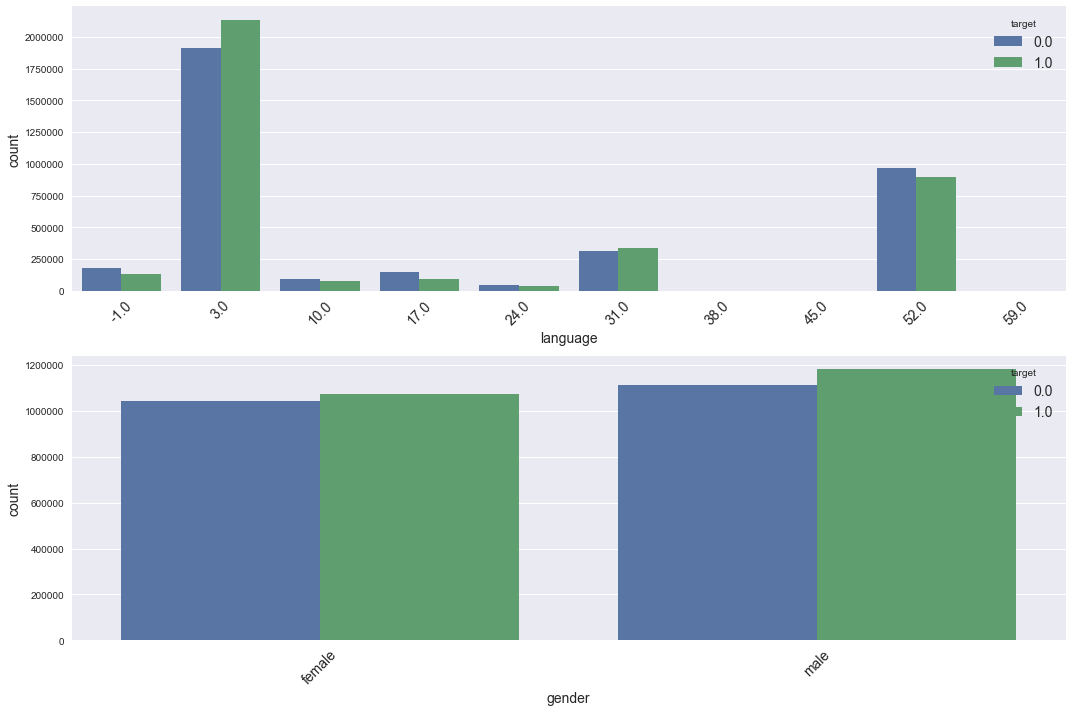

In [33]:
n = train.shape[0]

plt.figure(figsize=(15,10))
plot_columns=['language','gender']
for i, col in enumerate(plot_columns):
    plt.subplot(len(plot_columns),1,i+1)
    sns.countplot(x=col, hue='target', data =df[:n].loc[:, [col,'target']])
    plt.xticks(rotation=45, fontsize=14)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('count', fontsize=14)
    plt.legend(loc=1, title='target', prop={'size':14})
plt.tight_layout()
plt.show()

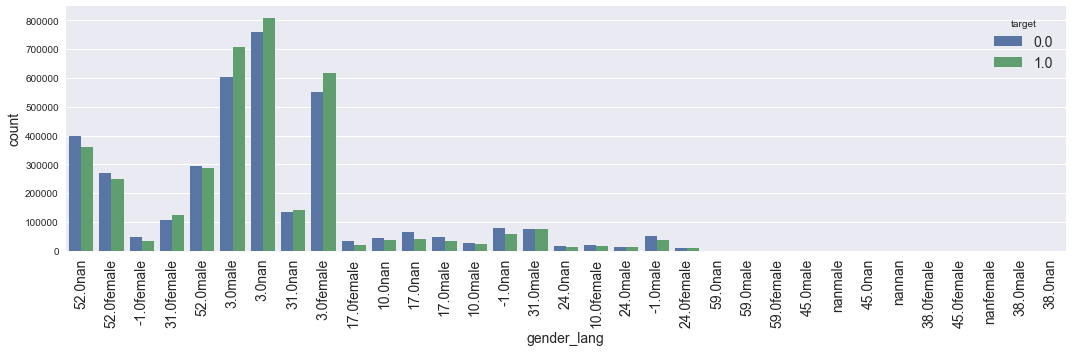

In [34]:
df['gender_lang']=df['language'].map(str)+ df['gender'].map(str)

plt.figure(figsize=(15,5))
plot_columns=['gender_lang']
for i, col in enumerate(plot_columns):
    plt.subplot(len(plot_columns),1,i+1)
    sns.countplot(x=col, hue='target', data =df[:n].loc[:, [col,'target']])
    plt.xticks(rotation=90, fontsize=14)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('count', fontsize=14)
    plt.legend(loc=1, title='target', prop={'size':14})
plt.tight_layout()
plt.show()

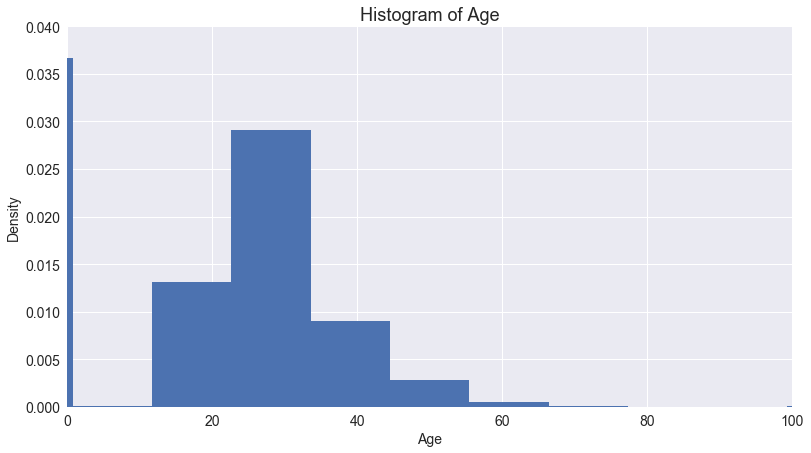

In [54]:
# extreme and missing
plt.figure(figsize=(13,7))
n, bins, patches = plt.hist(df.bd, 100, normed=1)

plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Histogram of Age', fontsize=18)
plt.axis([0, 100, 0, 0.04])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()


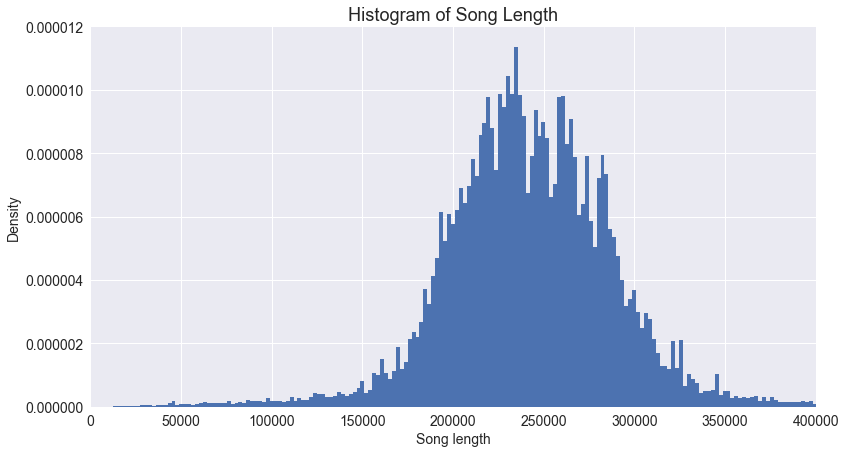

In [55]:
# extreme and missing
plt.figure(figsize=(13,7))
n, bins, patches = plt.hist(df.song_length.dropna(), 5000, normed=1)

plt.xlabel('Song length', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Histogram of Song Length', fontsize=18)
plt.axis([0, 400000, 0, 0.000012])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()


### Pair Plot and Correlation Matrix

In [56]:
df = pd.read_hdf('../data/df_all.hdf')

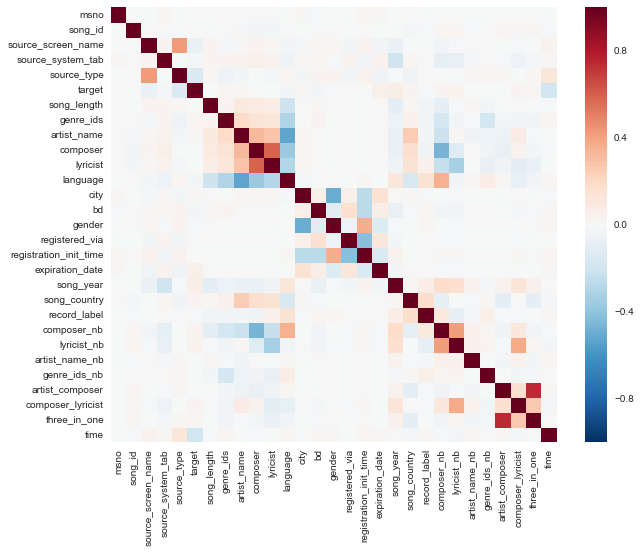

In [58]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="RdBu_r")
plt.show()